# Comparison of bAMFs

This notebooke compares the official `amf_total * Ak` with our bAMFs.

If our calculation of AMF is correct, they should be same. This can give detailed explanation of the cloud pressure issue in `amf_detail.ipynb`.

## Load data

In [1]:
import xarray as xr
import numpy as np
import proplot as plot

In [2]:
# read lut
lut = xr.open_dataset('S5P_OPER_LUT_NO2AMF_00000000T000000_99999999T999999_20160527T173500.nc')

# read s5p data
s5p_file = './S5P_TEST_L2__NO2____20190725T042743_20190725T060912_09219_01_020100_20190911T091424.nc'
s5p_root = xr.open_dataset(s5p_file, group='PRODUCT')
s5p_input = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/INPUT_DATA/')
s5p_geo = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/GEOLOCATIONS/')
s5p_detail = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/')

In [3]:
# load variables
Ak = s5p_root['averaging_kernel']
amf_total = s5p_root['air_mass_factor_total']
# albedo = s5p_input['surface_albedo']
albedo = s5p_input['surface_albedo_nitrogendioxide_window']
cld_albedo = s5p_input['cloud_albedo_crb']
amfTropo = s5p_root['air_mass_factor_troposphere']
amfStrato = s5p_detail['air_mass_factor_stratosphere']
crf = s5p_detail['cloud_radiance_fraction_nitrogendioxide_window']
tk = s5p_detail['temperature']
amf_geo = s5p_detail['amf_geo']

a = s5p_root['tm5_constant_a']
b = s5p_root['tm5_constant_b']
p_sfc = s5p_input['surface_pressure']
p_cld = s5p_input['cloud_pressure_crb']/1e2
apparent_scene_pressure = s5p_input['apparent_scene_pressure']/1e2
apparent_scene_pressure.attrs['units'] = 'hPa'

saa = s5p_geo['solar_azimuth_angle']
sza = s5p_geo['solar_zenith_angle']
vaa = s5p_geo['viewing_azimuth_angle']
vza = s5p_geo['viewing_zenith_angle']

mu0 = np.cos(np.deg2rad(sza)).rename('cosine_solar_zenith_angle')
mu = np.cos(np.deg2rad(vza)).rename('cosine_viewing_zenith_angle')
mu0.attrs = ''
mu.attrs = ''

raa = abs(vaa - saa)
raa = xr.where(raa <= 180, raa, 360 - raa).rename('relative_azimuth_angle')

# calculate AMFs
# AMF_geo = 1/mu + 1/mu0
# bAMF = (amfTropo + amfStrato)*Ak
bAMF = amf_total*Ak
# bAMF_normalized = bAMF/amf_geo
bAMF = bAMF.rename('bAMF')
# bAMF_normalized = bAMF_normalized.rename('bAMF_normalized')

# calculate pressure levels
base_p = (a[:, 0] + b[:, 0]*p_sfc).rename('base_pressure')/1e2
top_p = (a[:, 1] + b[:, 1]*p_sfc).rename('top_pressure')/1e2
p_sfc /=1e2

## Pick pixels

In [4]:
ds = xr.merge([amfTropo, amfStrato, Ak, tk,
               crf, albedo, cld_albedo, amf_geo,
               raa, mu0, mu,
               vaa, saa,
               p_sfc, p_cld, apparent_scene_pressure,
               base_p.drop_vars('vertices'),
               top_p.drop_vars('vertices'),
               bAMF, #bAMF_normalized
               ],
              )

# # crf=0
# scanline=194
# ground_pixel=310

# # high cloud 1
# scanline=211
# ground_pixel=278

# high cloud 2
scanline=211
ground_pixel=270

# # high cloud 3
# scanline=228
# ground_pixel=280

# # small difference
# scanline=211
# ground_pixel=290

ds = ds.isel(time=0, scanline=scanline, ground_pixel=ground_pixel)

In [5]:
ds

<xarray.Dataset>
Dimensions:                                         (layer: 34)
Coordinates:
    ground_pixel                                    float64 270.0
    scanline                                        float64 1.751e+03
    time                                            datetime64[ns] 2019-07-25
    latitude                                        float32 31.88
    longitude                                       float32 118.6
  * layer                                           (layer) float64 0.0 ... 33.0
Data variables: (12/19)
    air_mass_factor_troposphere                     float32 ...
    air_mass_factor_stratosphere                    float32 ...
    averaging_kernel                                (layer) float32 ...
    temperature                                     (layer) float32 ...
    cloud_radiance_fraction_nitrogendioxide_window  float32 ...
    surface_albedo_nitrogendioxide_window           float32 ...
    ...                                              ...
    surface_pressure                                float32 1e+03
    cloud_pressure_crb                              float32 130.0
    apparent_scene_pressure                         float32 270.7
    base_pressure                                   (layer) float32 1e+03 ......
    top_pressure                                    (layer) float32 992.7 ......
    bAMF                                            (layer) float32 0.0 ... 2...

## Check values

In [6]:
# the temperature correction factor, see TROPOMI ATBD file
ts = 220  # temperature of cross-section [K]
factor = 1 - 0.00316*(ds['temperature']-ts) + 3.39e-6*(ds['temperature']-ts)**2

In [7]:
# print parameters
print('crf', ds['cloud_radiance_fraction_nitrogendioxide_window'].values)
print('surface_albedo', ds['surface_albedo_nitrogendioxide_window'].values)
print('surface_pressure', ds['surface_pressure'].values)
print('relative_azimuth_angle', ds['relative_azimuth_angle'].values)
print('cosine_solar_zenith_angle', ds['cosine_solar_zenith_angle'].values)
print('cosine_viewing_zenith_angle', ds['cosine_viewing_zenith_angle'].values)
# print('bAMF_normalized', ds['bAMF_normalized'].values)

crf 0.9386997222900391
surface_albedo 0.05858064442873001
surface_pressure 1000.4456
relative_azimuth_angle 22.250679
cosine_solar_zenith_angle 0.9417936
cosine_viewing_zenith_angle 0.9759316


## Calculate bAMFs

In [8]:
def cal_bamf(lut, p_full_level, albedo, cld_albedo, p_sfc, p_cld, dphi, mu0, mu):
    '''Calculate the Box-AMFs at full levels based on the LUT file

    Args:
        - p_level: pressure at full level
        - albedo: Surface albedo
        - cld_albedo: Cloud albedo
        - p_sfc: Surface pressure
        - p_cld: Cloud pressure
        - dphi: Relative azimuth angle
        - mu: Cosine of viewing zenith angle
        - mu0: Cosine of solar zenith angle
        - amf: Box air mass factor
    '''

#     da = lut['amf'].assign_coords(p=np.log(lut['amf'].p), p_surface=np.log(lut['amf'].p_surface))
    da = lut['amf']#.assign_coords(p=np.log(lut['amf'].p), p_surface=np.log(lut['amf'].p_surface))
#     da = da.where(da>0, 0)

    bAmfClr_p = da.interp(albedo=albedo,
                                  p_surface=p_sfc,
#                                   p_surface=np.log(p_sfc),
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  )

#     print(cld_albedo, p_cld, dphi, mu0, mu)
    
    bAmfCld_p = da.interp(albedo=cld_albedo,
                                  p_surface=p_cld,
#                                   p_surface=np.log(p_cld),
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  )

    # interpolate to TM5 full pressure levels
#     bAmfClr = bAmfClr_p.interp(p=np.log(p_full_level.values))
#     bAmfCld = bAmfCld_p.interp(p=np.log(p_full_level.values))
    bAmfClr = bAmfClr_p.interp(p=p_full_level.values)
    bAmfCld = bAmfCld_p.interp(p=p_full_level.values)

    return bAmfClr_p, bAmfClr, bAmfCld_p, bAmfCld

def cal_bamf_nan(lut, p_full_level, albedo, p_sfc, dphi, mu0, mu):
    '''Calculate the Box-AMFs at full levels based on the LUT file

    Args:
        - p_level: pressure at full level
        - albedo: Surface albedo
        - cld_albedo: Cloud albedo
        - p_sfc: Surface pressure
        - p_cld: Cloud pressure
        - dphi: Relative azimuth angle
        - mu: Cosine of viewing zenith angle
        - mu0: Cosine of solar zenith angle
        - amf: Box air mass factor
    '''

    da = lut['amf']#.assign_coords(p=np.log(lut['amf'].p), p_surface=np.log(lut['amf'].p_surface))
    da = da.where(da>0, 0)

    bAmfClr_p = da.interp(albedo=albedo,
#                                   p_surface=p_sfc,
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  )

    # set 0 to nan and extrapolate the data
    bAmfClr_p = bAmfClr_p.where(bAmfClr_p>0)
    bAmfClr_p = bAmfClr_p.interp(p_surface=p_sfc).sortby('p')
#     bAmfClr_p = bAmfClr_p.interp(p_surface=np.log(p_sfc)).sortby('p')
    bAmfClr_p = bAmfClr_p.interpolate_na(dim='p', method='linear', use_coordinate='p', fill_value="extrapolate")

    # interpolate to TM5 full pressure levels
    bAmfClr = bAmfClr_p.interp(p=p_full_level.values)

    return bAmfClr_p, bAmfClr, bAmfCld_p, bAmfCld

In [9]:
p = (ds['base_pressure']+ds['top_pressure'])/2

bAmfClr_p, bAmfClr, bAmfCld_p, bAmfCld= cal_bamf(lut, p,
                            ds['surface_albedo_nitrogendioxide_window'],
                            ds['cloud_albedo_crb'],
                            ds['surface_pressure'],
                            ds['cloud_pressure_crb'],
                            ds['relative_azimuth_angle'],
                            ds['cosine_solar_zenith_angle'],
                            ds['cosine_viewing_zenith_angle'],     
                            )

bAmfClr_p_nan, bAmfClr_nan, bAmfCld_p_nan, bAmfCld_nan = cal_bamf_nan(lut, p,
                            ds['surface_albedo_nitrogendioxide_window'],
                            ds['surface_pressure'],
                            ds['relative_azimuth_angle'],
                            ds['cosine_solar_zenith_angle'],
                            ds['cosine_viewing_zenith_angle'],     
                            )

## Plot bAMFClr and bAMFCld

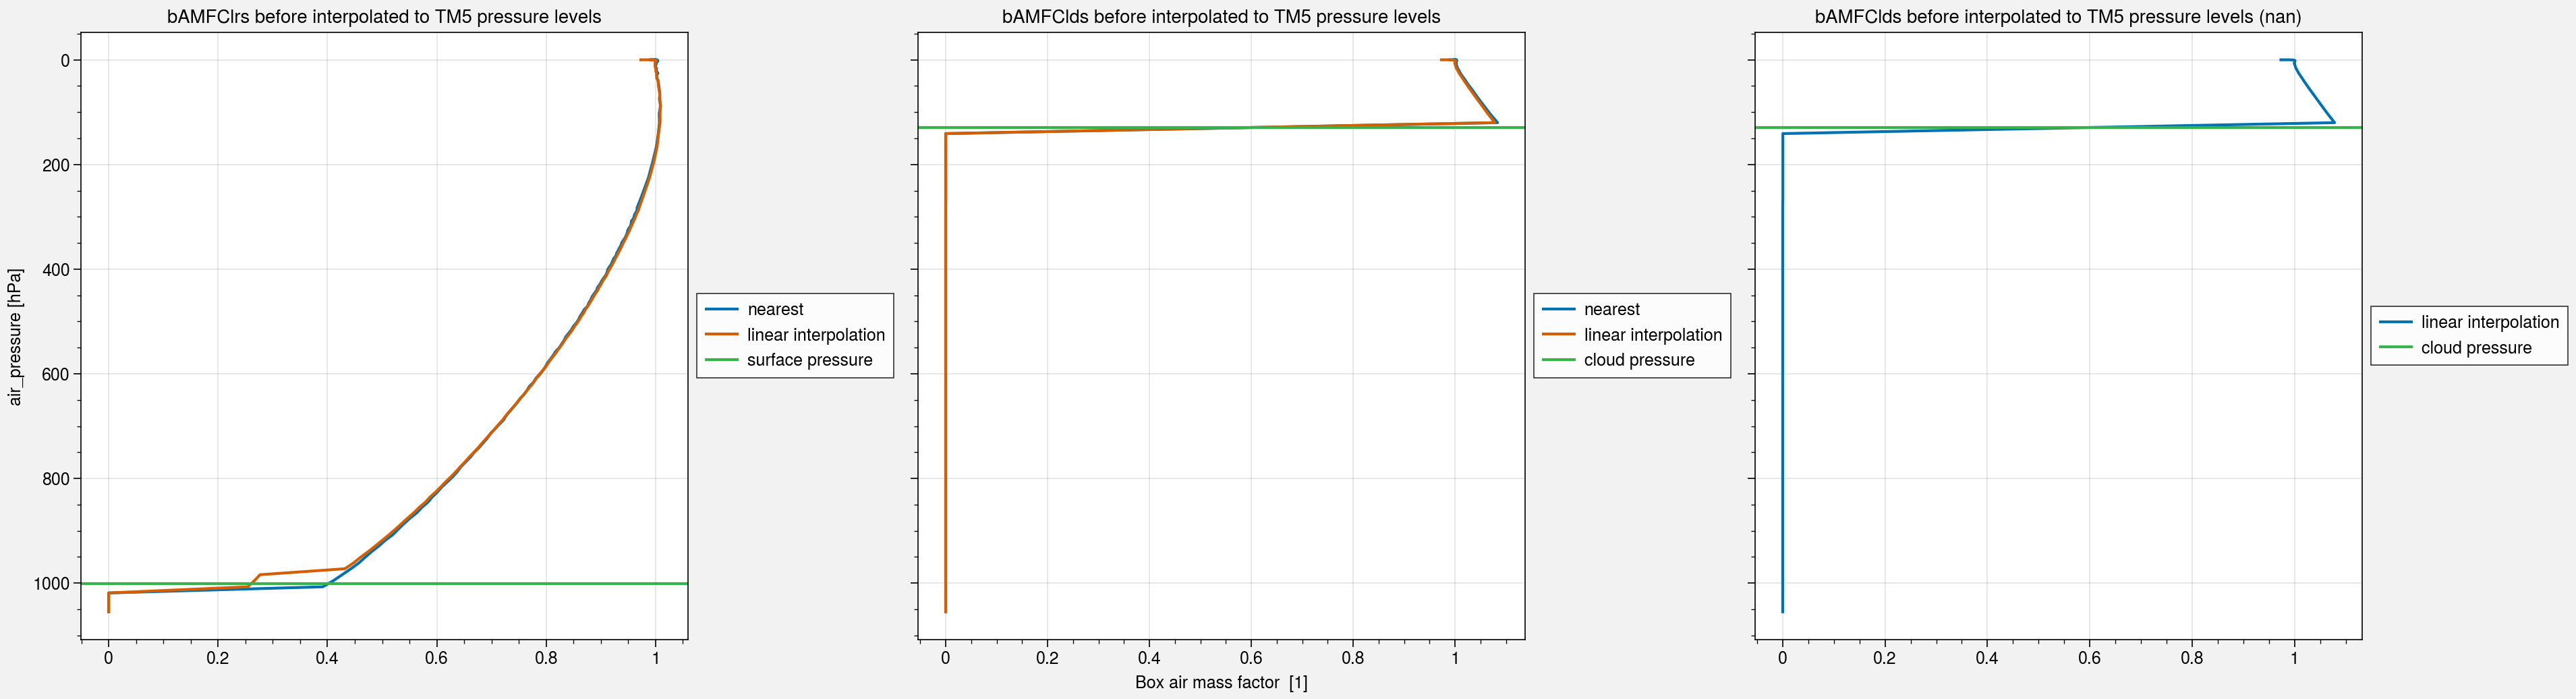

In [10]:
fig, axs = plot.subplots(axwidth=4.5, ncols=3)

ax = axs[0]
bAmfClr_p_nearest = lut['amf'].sel(albedo=ds['surface_albedo_nitrogendioxide_window'],
               p_surface=ds['surface_pressure'],
               dphi=ds['relative_azimuth_angle'],
               mu0=ds['cosine_solar_zenith_angle'],
               mu=ds['cosine_viewing_zenith_angle'], method='nearest')

bAmfClr_nearest = bAmfClr_p_nearest.sel(p=p, method='nearest')

l1 = bAmfClr_p_nearest.plot(ax=ax, y='p', yincrease=False, label='nearest')
l2 = bAmfClr_p.plot(ax=ax, y='p', yincrease=False, label='linear interpolation')
l3 = ax.axhline(ds['surface_pressure'], color='green7', label='surface pressure')

ax.legend([l1, l2, l3], ncols=1, loc='r')
ax.format(title='bAMFClrs before interpolated to TM5 pressure levels')

ax = axs[1]
bAmfCld_p_nearest = lut['amf'].sel(albedo=ds['cloud_albedo_crb'],
               p_surface=ds['cloud_pressure_crb'],
               dphi=ds['relative_azimuth_angle'],
               mu0=ds['cosine_solar_zenith_angle'],
               mu=ds['cosine_viewing_zenith_angle'], method='nearest')
bAmfCld_nearest = bAmfCld_p_nearest.sel(p=p, method='nearest')

l1 = bAmfCld_p_nearest.plot(ax=ax, y='p', yincrease=False, label='nearest')
l2 = bAmfCld_p.plot(ax=ax, y='p', yincrease=False, label='linear interpolation')
l3 = ax.axhline(ds['cloud_pressure_crb'], color='green7', label='cloud pressure')

ax.legend([l1, l2, l3], ncols=1, loc='r')
ax.format(title='bAMFClds before interpolated to TM5 pressure levels')


ax = axs[2]
l1 = bAmfCld_p_nan.plot(ax=ax, y='p', yincrease=False, label='linear interpolation')
l2 = ax.axhline(ds['cloud_pressure_crb'], color='green7', label='cloud pressure')

ax.legend([l1, l2], ncols=1, loc='r')
ax.format(title='bAMFClds before interpolated to TM5 pressure levels (nan)')


# fig.savefig('bAMFs_interp_nearest.png')

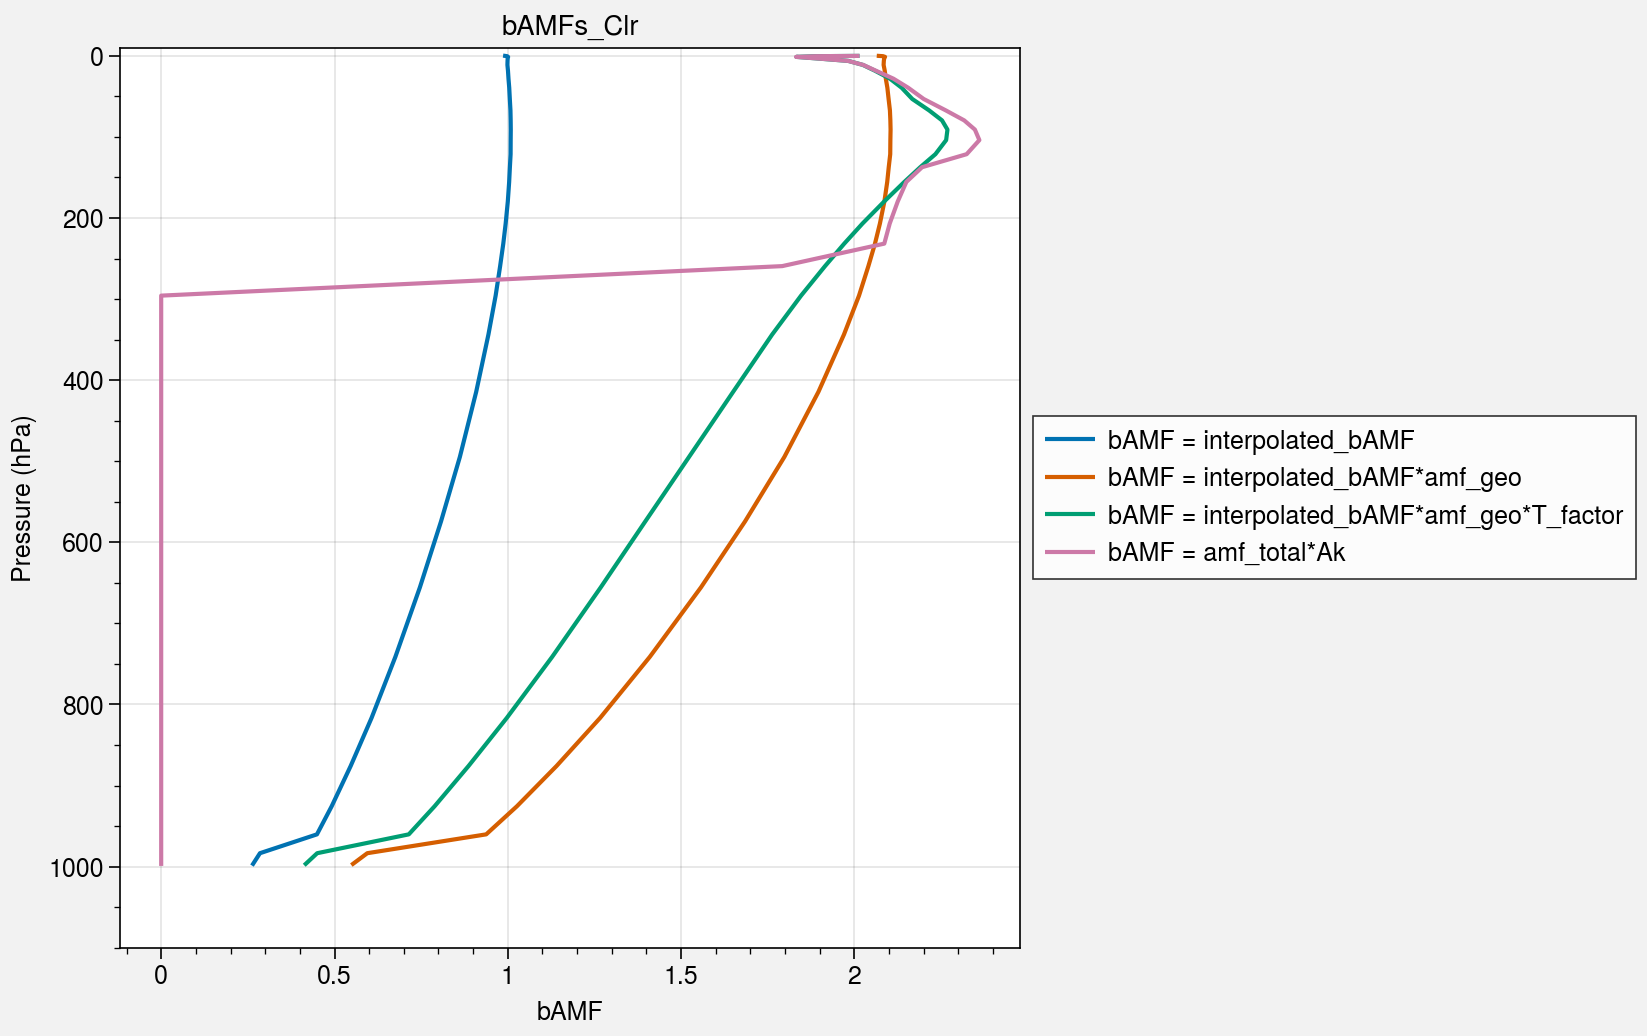

In [11]:
# plot
fig, axs = plot.subplots(axwidth=4.5)

l0 = axs.plot(bAmfClr, p, label='bAMF = interpolated_bAMF')
l1 = axs.plot(bAmfClr*ds['amf_geo'], p, label='bAMF = interpolated_bAMF*amf_geo')
l2 = axs.plot(bAmfClr*ds['amf_geo']*factor.values, p, label='bAMF = interpolated_bAMF*amf_geo*T_factor')
l3 = axs.plot(ds['bAMF'], p, label='bAMF = amf_total*Ak')

axs.legend([l0, l1, l2, l3], ncols=1, loc='r')
axs.format(ylim=(1100, -10),
           xlabel='bAMF',
           ylabel='Pressure (hPa)',
           title='bAMFs_Clr')

# fig.savefig('bAMFs_Clr.png')

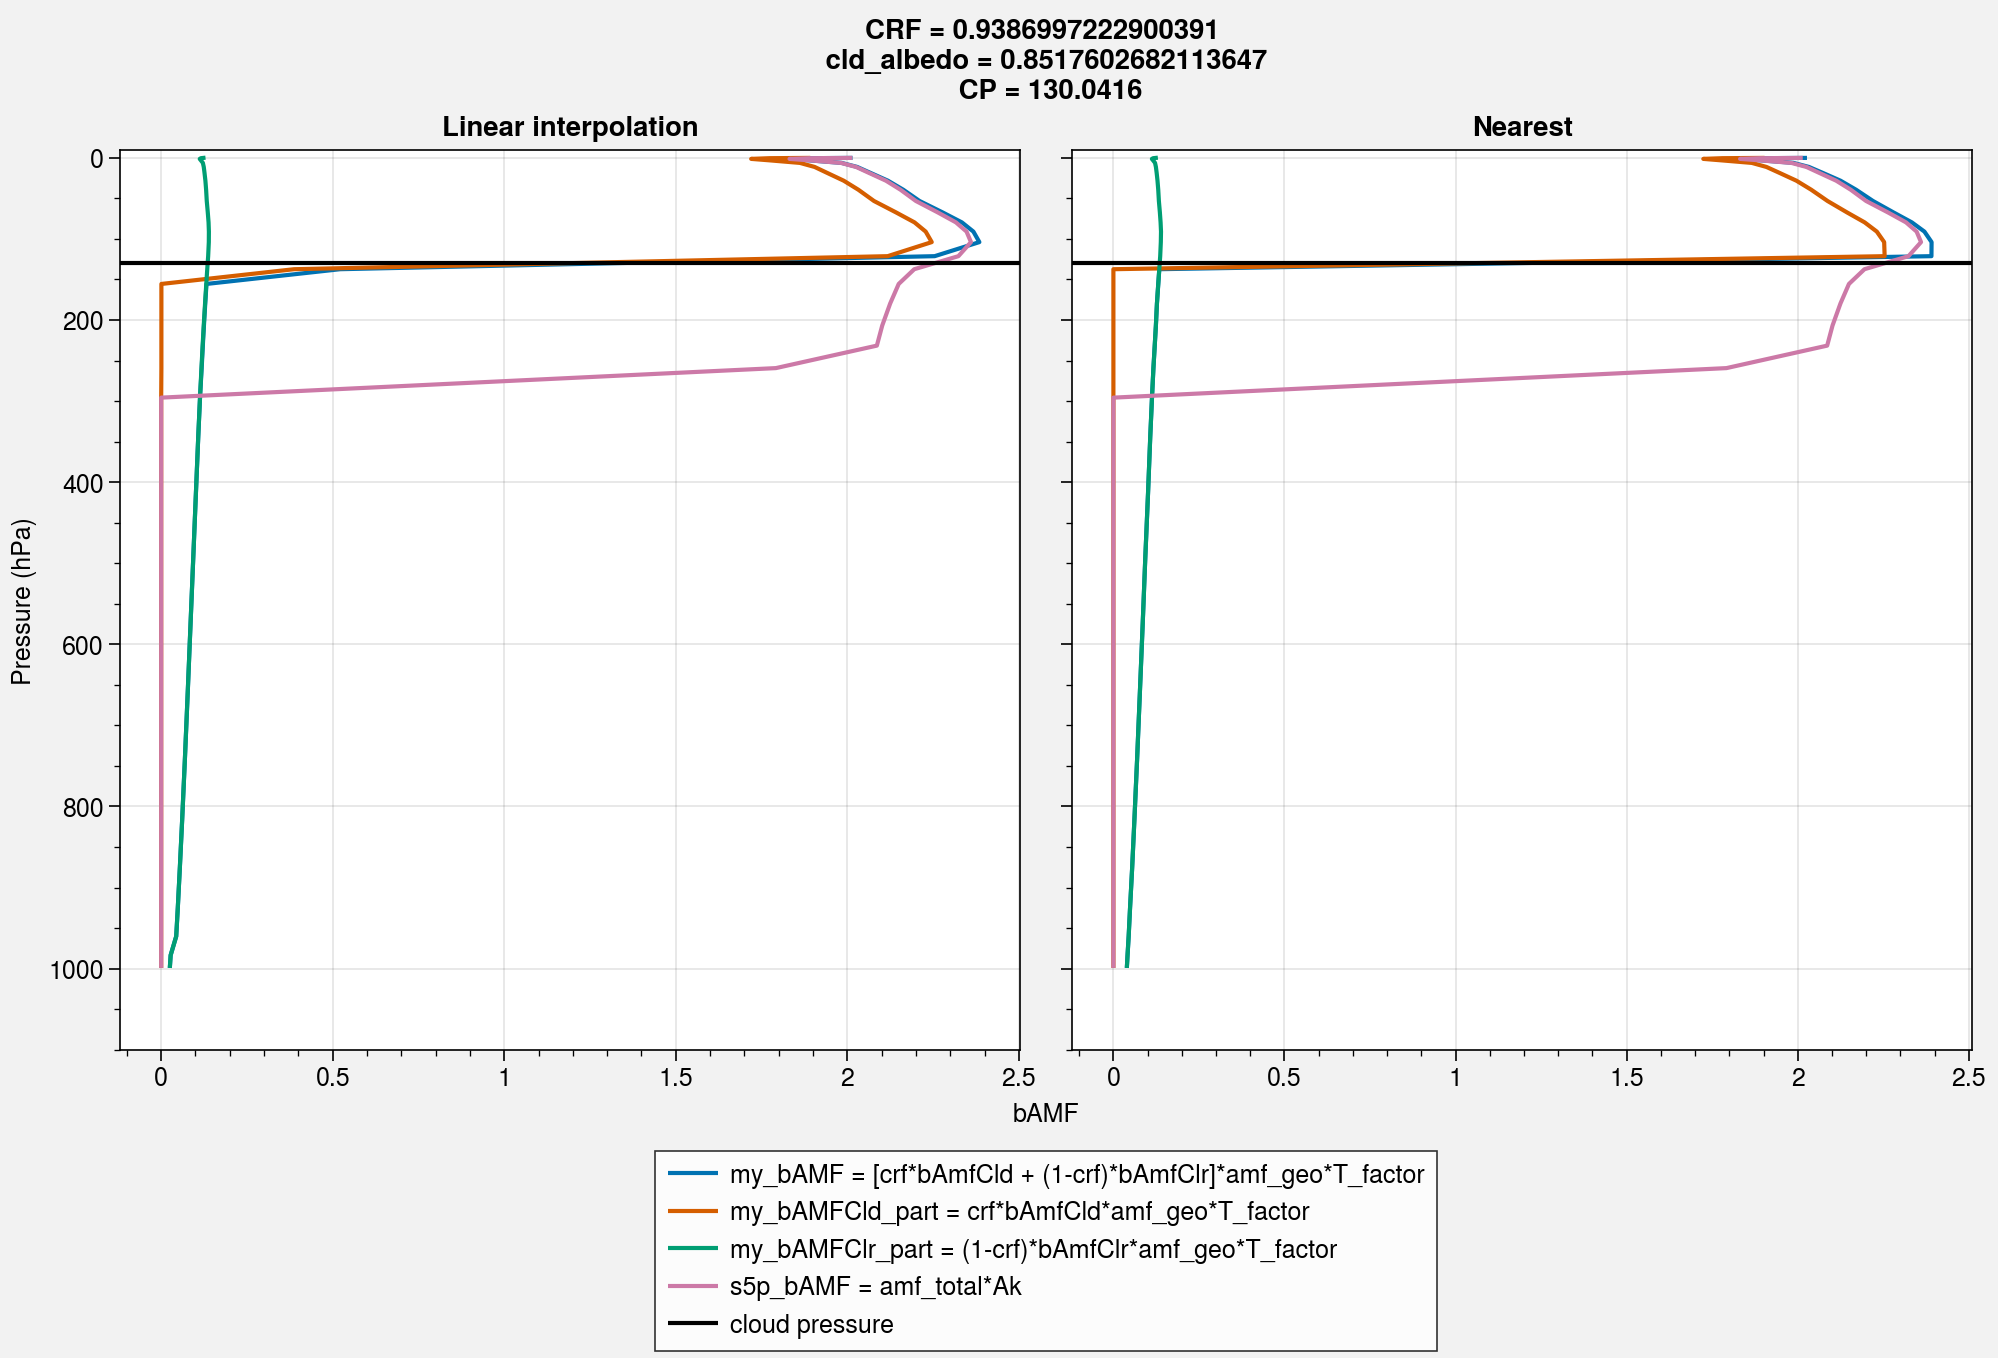

In [12]:
# plot
fig, axs = plot.subplots(axwidth=4.5, ncols=2)

bAmf = (ds['cloud_radiance_fraction_nitrogendioxide_window']*bAmfCld + (1- ds['cloud_radiance_fraction_nitrogendioxide_window'])*bAmfClr)*ds['amf_geo']*factor.values
bAmf_nearest = (ds['cloud_radiance_fraction_nitrogendioxide_window']*bAmfCld_nearest + (1- ds['cloud_radiance_fraction_nitrogendioxide_window'])*bAmfClr_nearest)*ds['amf_geo']*factor.values

ax = axs[0]
l0 = ax.plot(bAmf, p, label='my_bAMF = [crf*bAmfCld + (1-crf)*bAmfClr]*amf_geo*T_factor')
l1 = ax.plot(bAmfCld*ds['cloud_radiance_fraction_nitrogendioxide_window']*ds['amf_geo']*factor.values,
              p, label='my_bAMFCld_part = crf*bAmfCld*amf_geo*T_factor')
l2 = ax.plot(bAmfClr*(1-ds['cloud_radiance_fraction_nitrogendioxide_window'])*ds['amf_geo']*factor.values,
              p, label='my_bAMFClr_part = (1-crf)*bAmfClr*amf_geo*T_factor')
l3 = ax.plot(ds['bAMF'], p, label='s5p_bAMF = amf_total*Ak')
l4 = ax.axhline(ds['cloud_pressure_crb'], color='black', label='cloud pressure')

ax = axs[1]
l0 = ax.plot(bAmf_nearest, p, label='my_bAMF = [crf*bAmfCld + (1-crf)*bAmfClr]*amf_geo*T_factor')
l1 = ax.plot(bAmfCld_nearest*ds['cloud_radiance_fraction_nitrogendioxide_window']*ds['amf_geo']*factor.values,
              p, label='my_bAMFCld_part = crf*bAmfCld*amf_geo*T_factor')
l2 = ax.plot(bAmfClr_nearest*(1-ds['cloud_radiance_fraction_nitrogendioxide_window'])*ds['amf_geo']*factor.values,
              p, label='my_bAMFClr_part = (1-crf)*bAmfClr*amf_geo*T_factor')
l3 = ax.plot(ds['bAMF'], p, label='s5p_bAMF = amf_total*Ak')
l4 = ax.axhline(ds['cloud_pressure_crb'], color='black', label='cloud pressure')

fig.legend([l0, l1, l2, l3, l4], ncols=1, loc='b')
axs.format(ylim=(1100, -10),
           xlabel='bAMF',
           ylabel='Pressure (hPa)',
           collabels=['Linear interpolation', 'Nearest'],
          )

axs.format(suptitle = 'CRF = %s \n cld_albedo = %s \n CP = %s' % (ds['cloud_radiance_fraction_nitrogendioxide_window'].values, ds['cloud_albedo_crb'].values, ds['cloud_pressure_crb'].values))

# fig.savefig('bAMFs_cld_pixel.png')

So, the official bAMF uses the linear interpolation and the temperature correction has been applied.

The different level of kink is caused by the cloud pressure. Let's check it now.

In [13]:
bAmfClr = bAmfClr.rename('bAmfClr')
bAmfCld = bAmfCld.rename('bAmfCld').drop_vars(['albedo', 'p_surface'])

bAmfClr_corr = bAmfClr*ds['amf_geo']*factor.values
bAmfCld_corr = bAmfCld*ds['amf_geo']*factor.values

bAmfClr_corr = bAmfClr_corr.rename('bAmfClr_corr')
bAmfCld_corr = bAmfCld_corr.rename('bAmfCld_corr')

bAmfClr_corr.attrs['description'] = 'bAmfClr_corr = bAmfClr*amf_geo*t_factor'
bAmfCld_corr.attrs['description'] = 'bAmfCld_corr = bAmfCld*amf_geo*t_factor'

In [14]:
merge_ds = xr.merge([bAmfClr, bAmfCld, bAmfClr_corr, bAmfCld_corr,
                     ds['amf_geo'], factor.rename('t_factor'),
                     ds['cloud_albedo_crb'],
                     ds['cloud_pressure_crb'],
                     ds['apparent_scene_pressure'],
                     ds['cloud_radiance_fraction_nitrogendioxide_window'],
                     amf_total.isel(time=0, scanline=scanline, ground_pixel=ground_pixel),
                     Ak.isel(time=0, scanline=scanline, ground_pixel=ground_pixel)])

In [15]:
# coords = list(merge_ds.coords.keys())
# coords.remove('p')
# coords.remove('layer')

# merge_ds.reset_coords(coords).to_netcdf('export4.nc')

In [16]:
merge_ds

<xarray.Dataset>
Dimensions:                                         (layer: 34, p: 34)
Coordinates:
    albedo                                          float64 0.05858
    p_surface                                       float32 1e+03
    dphi                                            float32 22.25
    mu0                                             float32 0.9418
    mu                                              float32 0.9759
    ground_pixel                                    float64 270.0
    scanline                                        float64 1.751e+03
    time                                            datetime64[ns] 2019-07-25
    latitude                                        float64 31.88
    longitude                                       float64 118.6
  * p                                               (p) float32 996.6 ... 0.0...
  * layer                                           (layer) float64 0.0 ... 33.0
Data variables:
    bAmfClr                                         (p) float64 0.2652 ... 0....
    bAmfCld                                         (p) float64 0.0 ... 0.9925
    bAmfClr_corr                                    (p) float64 0.4171 ... 2.009
    bAmfCld_corr                                    (p) float64 0.0 ... 2.009
    amf_geo                                         float64 2.086
    t_factor                                        (layer) float32 0.7537 .....
    cloud_albedo_crb                                float64 0.8518
    cloud_pressure_crb                              float32 130.0
    apparent_scene_pressure                         float32 270.7
    cloud_radiance_fraction_nitrogendioxide_window  float64 0.9387
    air_mass_factor_total                           float32 ...
    averaging_kernel                                (layer) float32 ...

In [17]:
def plot_test(lut, ds, test_cp):
    crf = ds['cloud_radiance_fraction_nitrogendioxide_window']    
    ds_test = ds.copy()
    fig, axs = plot.subplots(ncols=3, nrows=3)
    
    for index, cp in enumerate(test_cp):
        ax = axs[index]
        ds_test['cloud_pressure_crb'] = cp #175.98703

        bAmfClr_p, bAmfClr, bAmfCld_p, bAmfCld= cal_bamf(lut, ds_test.p,
                                    ds_test['albedo'],
                                    ds_test['cloud_albedo_crb'],
                                    ds_test['p_surface'],
                                    ds_test['cloud_pressure_crb'],
                                    ds_test['dphi'],
                                    ds_test['mu0'],
                                    ds_test['mu'],     
                                    )

        ds_test['bAmfClr_corr'] = bAmfClr.drop_vars(['albedo', 'p_surface', 'dphi', 'mu0', 'mu'])*ds_test['amf_geo']*ds_test['t_factor'].values
        ds_test['bAmfCld_corr'] = bAmfCld.drop_vars(['albedo', 'p_surface', 'dphi', 'mu0', 'mu'])*ds_test['amf_geo']*ds_test['t_factor'].values

        bAmf_test = (1-crf)*ds_test['bAmfClr_corr'] + crf*ds_test['bAmfCld_corr']
        bAmf_official = ds_test['air_mass_factor_total'] * ds_test['averaging_kernel']

        l1 = ax.plot(ds_test['bAmfClr_corr'], bAmf.p,  label='bAmfClr_corr_Xin')
        l2 = ax.plot(ds_test['bAmfCld_corr'], bAmf.p,  label='bAmfCld_corr_Xin')
        l3 = ax.plot(bAmf_official, bAmf.p, color='pink7', label='bAmf_official')
        
        l4 = ax.plot(bAmf_test, bAmf.p, color='green9', label='bAmf_Xin')
        l5 = ax.axhline(ds_test['cloud_pressure_crb'], color='k', label='cloud pressure')

        ax.scatter(bAmf_official, bAmf.p, color='pink7')
        ax.scatter(bAmf_test, bAmf.p, color='green9')
        ax.format(title=f'CP = {cp} hPa')

    info = f"({ds['time'].dt.strftime('%Y%m%d').values}) \n \
             ground_pixel: {ds['ground_pixel'].values} \n \
             scanline: {ds['scanline'].values} \n \
             crf: {ds['cloud_radiance_fraction_nitrogendioxide_window'].values} \n \
             apparent_scene_pressure: {ds['apparent_scene_pressure'].values} \n \
             cloud_pressure_crb: {ds['cloud_pressure_crb'].values} \
             "

    axs.format(xlim=(-0.1, 2.5),
              ylim=(1100, -50),
              xlabel='bAMFs',
              ylabel='Pressure (hPa)',
              suptitle=f"Sensitivity test of Cloud Pressure \n {info}",
              )

#     axs.text(0.5, 1.1, info,
#              horizontalalignment='center',
#              verticalalignment='center',
#              transform = axs.transAxes)
    
#     ax.annotate(info, xy=(1,0), xycoords="axes fraction",
#                     xytext=(5,-5), textcoords="offset points",
#                     ha="left", va="top")
    
    fig.legend([l1, l2, l3, l4, l5], loc='r', ncols=1)

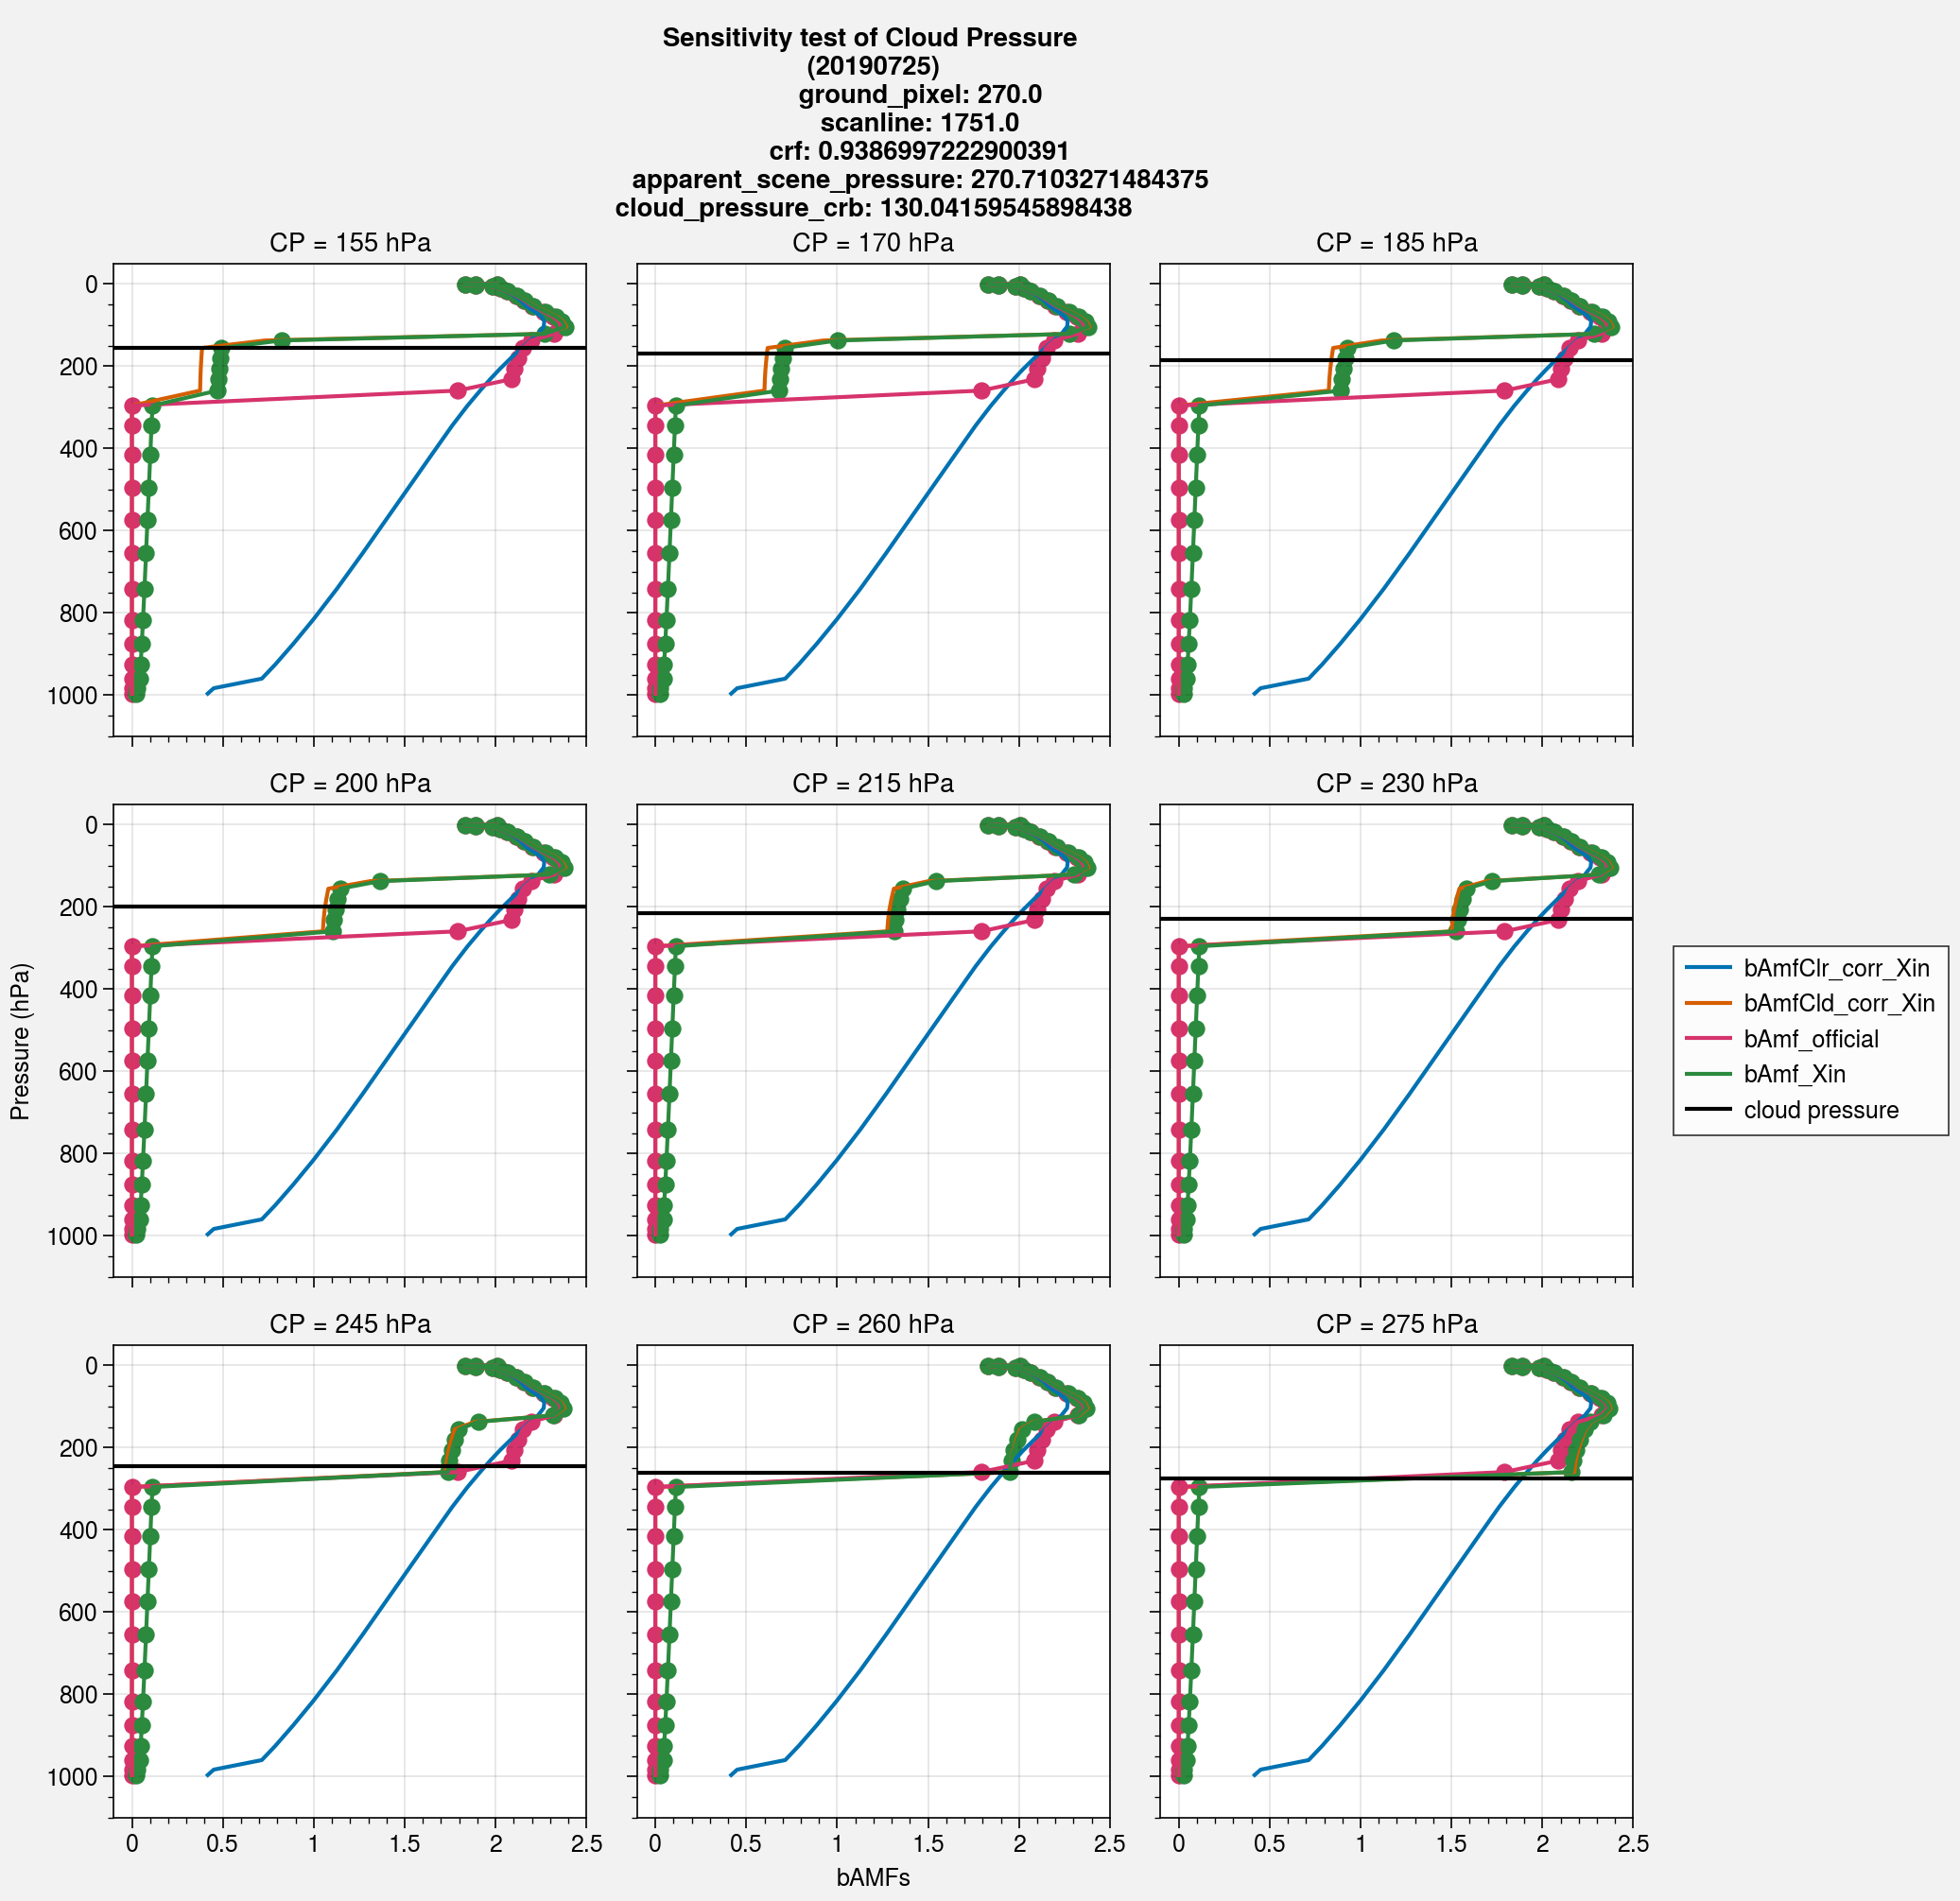

In [18]:
plot_test(lut, merge_ds, test_cp=plot.arange(155, 275, 15))

When we use the `apparent_scene_pressure` with CRF ~ 1, the profile looks fine. This will be fixed in TROPOMI version 2.